In [1]:
from typing import Callable, Optional, Union, TypedDict
import warnings

from typeguard import check_type
from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from ezephys import stimtools as st
from ezephys import pltools

# Setup

Configure global variables.

In [2]:
TIMESTEP_WIDTH = 0.1

Simulation code for the model.

In [3]:
def get_exponential_kernel(
    tau_ms: float, kernel_length_ms: float, dt: float = TIMESTEP_WIDTH
) -> np.ndarray:
    t = np.arange(0, kernel_length_ms, dt)
    IRF_filter = np.exp(-t / tau_ms)
    IRF_filter = IRF_filter/sum(IRF_filter)
    return IRF_filter


def get_sigmoid(loc: float, sensitivity: float, gain: float) -> Callable[[np.ndarray], np.ndarray]:
    def sigmoid(x):
        return gain / (1 + np.exp(-(x - loc) / sensitivity))
    return sigmoid


def get_causal_filter(kernel: np.ndarray) -> Callable[[np.ndarray], float]:
    """Get a function that applies a filter to the end of a timeseries, returning a scalar."""
    flipped_kernel = np.flip(kernel).copy()
    if not np.isclose(flipped_kernel.sum(), 1.):
        warnings.warn('Kernel integral is not 1.')
    
    def causal_filter(timeseries: np.ndarray) -> float:
        """Filter the end of a timeseries, returning a scalar.
        
        Equivalent to the convolution of the filter kernel with
        timeseries, evaluated at the timepoint just after the end
        of the timeseries.
        
        """
        assert np.ndim(timeseries) == 1
        return np.dot(
            flipped_kernel[max(0, len(flipped_kernel) - len(timeseries)):],
            timeseries[max(0, len(timeseries) - len(flipped_kernel)):]
        )
    
    return causal_filter


class TwoCompartmentNeuronState(TypedDict):
    """The internal state of a two compartment neuron at a single time point."""
    Vd_linear: float  # Dendritic voltage generated by external inputs
    Vd_tot: float  # sigma(Vd_linear + Vs_tot)
    Vs_linear: float  # Somatic voltage generated by external inputs
    Vs_ad: float  # Somatic adaptation
    Vs_tot: float  # Vs_linear + Vs_Na + Vd_tot


class TwoCompartmentNeuronStateRecord(dict):
    """Recording of the time-varying state of a two-compartment neuron."""
    def __init__(self, capacity: int, dt: float, **kwargs):
        """Initialze the recording.
        
        This method should not be considered public. 
        TwoCompartmentNeuronStateRecords should only be created by 
        a TwoCompartmentNeuron.
        
        """
        self.dt = dt
        self.__timestep = 0
        self.__capacity = capacity
        self.__finalized = False
        super().__init__(**kwargs)
        
    @property
    def time(self) -> np.ndarray:
        """Get a time support vector for plotting."""
        return np.arange(0, len(self)) * self.dt
        
    def __len__(self):
        if self.__finalized:
            return self.__capacity
        else:
            raise RuntimeError('Length of partially-filled recorder is undefined.')
        
    def _record(self, state: TwoCompartmentNeuronState):
        """Record a TwoCompartmentNeuronState."""
        if self.__finalized:
            raise RuntimeError('Recorder capacity exceeded.')
        
        # Check that argument state is a valid TwoCompartmentNeuronState.
        # This guarantees that all state variables have been set correctly.
        check_type('state', state, TwoCompartmentNeuronState)
        
        # Append state to record.
        for state_var_name, state_var_val in state.items():
            if state_var_name in self:
                self[state_var_name].append(state_var_val)
            else:
                self[state_var_name] = [state_var_val]
        
        if self.__timestep == self.__capacity - 1:
            # Recorder is full. Finalize automatically.
            self._finalize()
        else:
            self.__timestep += 1
                
    def _finalize(self):
        """Finish recording and make the recorder read-only."""
        if not self.__finalized:
            assert self.__capacity > self.__timestep
            self.__capacity = self.__timestep + 1  # Shrink capacity to fit.

            # Coerce state records to read-only arrays.
            # Store length for double-checking that all records have equal
            # num timesteps.
            state_record_lengths = []
            for state_var_name, state_var_val in self.items():
                self[state_var_name] = np.asarray(state_var_val)
                self[state_var_name].flags.writeable = False
                state_record_lengths.append(len(self[state_var_name]))
            
            # Raise an error if not all records have equal number of timesteps.
            if not all([self.__capacity == l for l in state_record_lengths]):
                raise RuntimeError(
                    'Recorder corrupted: not all state records have expected length.'
                )

            self.__finalized = True

class TwoCompartmentNeuron:
    def __init__(
        self, 
        adaptation_kernel: np.ndarray, 
        dendritic_kernel: np.ndarray, 
        somatic_kernel: np.ndarray,
        sodium_nonlinearity: Union[Callable[[float], float], Callable[[np.ndarray], np.ndarray]],
        dendritic_nonlinearity: Union[Callable[[float], float], Callable[[np.ndarray], np.ndarray]],
    ):
        # Attach callable causal filters
        self._adaptation_filter: Callable[[np.ndarray], float] = get_causal_filter(adaptation_kernel)
        self._somatic_filter: Callable[[np.ndarray], float] = get_causal_filter(somatic_kernel)
        self._dendritic_filter: Callable[[np.ndarray], float] = get_causal_filter(dendritic_kernel)
        
        # Attach nonlinearities. Will only be called with scalars.
        self._sodium_nonlinearity = sodium_nonlinearity
        self._dendritic_nonlinearity = dendritic_nonlinearity
        
        # Allocate an attribute to hold state variables.
        # This will always be None, except during a simulation.
        self.__state: Optional[TwoCompartmentNeuronState] = None
        
    def __call__(
        self, 
        somatic_input: np.ndarray, 
        dendritic_input: np.ndarray, 
        dt: float = TIMESTEP_WIDTH,
        initial_state: Optional[TwoCompartmentNeuronState] = None
    ) -> TwoCompartmentNeuronStateRecord:
        """Simulate the response of the model to a set of inputs."""
        assert np.ndim(somatic_input) == 1
        assert np.ndim(dendritic_input) == 1
        assert len(somatic_input) == len(dendritic_input)
        
        try:
            # Set the initial state of the neuron.
            if initial_state is None:
                # Set all variables to zero by default.
                self.__state = TwoCompartmentNeuronState(
                    Vd_linear=0., Vd_tot=0., Vs_linear=0., Vs_ad=0., Vs_tot=0.
                )
            else:
                self.__state = initial_state

            # Allocate a TwoCompartmentStateRecorder to monitor the values of
            # state variables during the simulation. Capacity is len(input) + 1
            # because both the initial state and the state after the last
            # timestep of input are recorded.
            recorder = TwoCompartmentNeuronStateRecord(len(somatic_input), dt)

            # Run the simulation.
            for t_next in trange(1, len(somatic_input) + 1, leave=False):
                # Record current state.
                recorder._record(self.__state)

                # Update the internal state.
                self.__state = self._compute_next_state(
                    somatic_input, dendritic_input, recorder, t_next
                )
        finally:
            # Clear the state when the simulation is finished.
            self.__state = None
        
        # Finalize and return the record of states during the simulation.
        recorder._finalize()
        return recorder

    def _compute_next_state(
        self, 
        somatic_input: np.ndarray, 
        dendritic_input: np.ndarray, 
        state_history: TwoCompartmentNeuronStateRecord, 
        t_next: int
    ) -> TwoCompartmentNeuronState:
        next_state = TwoCompartmentNeuronState()
        
        # Compute somatic state variables at the next timestep.
        next_state['Vs_linear'] = self._somatic_filter(
            somatic_input[:t_next] + state_history['Vd_tot'][:t_next] - state_history['Vs_ad'][:t_next]
        )
        next_state['Vs_tot'] = self._sodium_nonlinearity(self.__state['Vs_linear'])
        next_state['Vs_ad'] = self._adaptation_filter(state_history['Vs_tot'][:t_next])
        
        # Compute dendritic state variables at the next timestep.
        next_state['Vd_linear'] = self._dendritic_filter(
            dendritic_input[:t_next] + state_history['Vs_tot'][:t_next]
        )
        next_state['Vd_tot'] = self._dendritic_nonlinearity(
            self.__state['Vd_linear']
        )
        
        # Ensure that next state has been set correctly.
        check_type('next_state', next_state, TwoCompartmentNeuronState)
        
        return next_state

Set colour scheme and labels/definitions for all variables to be plotted.

In [4]:
labels = {
    'Vs_ad': r'$V_{Na}(t) = \sigma((\kappa_{Na} * I_s)(t))$',
    'Vs_linear': r'$(\kappa_s * I_s)(t)$',
    'Vs_tot': r'$V_s(t) = (\kappa_s * I_s)(t) + V_{Na}(t) + V_d(t)$',
    'Vd_linear': r'$(\kappa_d * I_d)(t)$',
    'bap': r'BAP ($V_s(t)$)',
    'Vd_tot': r'$V_d(t) = \sigma\left((\kappa_d * I_d)(t) + V_s(t)\right)$'
}
colors = {
    'Vs_ad': 'red',
    'Vs_linear': 'black',
    'Vs_tot': 'orange',
    'Vd_linear': 'black',
    'bap': 'orange',
    'Vd_tot': 'green',
}

Create the model.

In [5]:
adaptation_kernel = get_exponential_kernel(tau_ms=20., kernel_length_ms=200.)
adaptation_kernel *= 2.
adaptation_kernel[0] = 1.
model = TwoCompartmentNeuron(
    adaptation_kernel=adaptation_kernel,
    somatic_kernel=get_exponential_kernel(tau_ms=10., kernel_length_ms=100.),
    dendritic_kernel=get_exponential_kernel(tau_ms=5., kernel_length_ms=50.),
    sodium_nonlinearity=lambda x: 0. if x < 1.5 else 30.,
    dendritic_nonlinearity=get_sigmoid(2.5, 0.25, 2.)
)

<ipython-input-3-82a2e0bb94ae>:20: UserWarning: Kernel integral is not 1.
  warnings.warn('Kernel integral is not 1.')


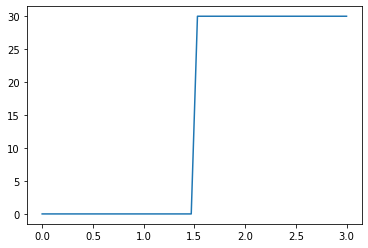

In [6]:
x = np.linspace(0, 3)
plt.plot(x, [model._sodium_nonlinearity(x_) for x_ in x])

Helper for generating synaptic pulse input.

# Demos

## Calcium plateau potential

"Plateau" potential is shown in green in the top panel.

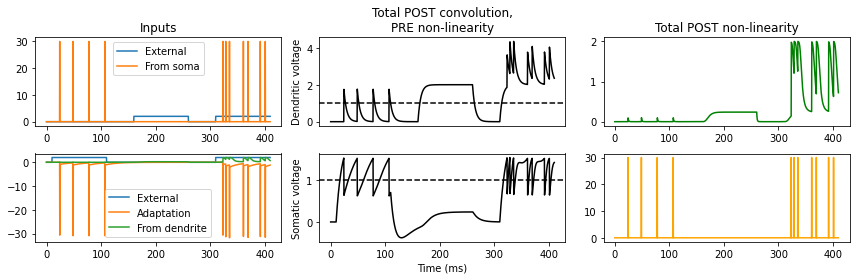

In [7]:
somatic_input = 0.2 * st.StepStimulus([10, 100, 50, 100, 50, 100], [0, 10, 0, 0, 0, 10], TIMESTEP_WIDTH).command.flatten()
dendritic_input = 0.2 * st.StepStimulus([10, 100, 50, 100, 50, 100], [0, 0, 0, 10, 0, 10], TIMESTEP_WIDTH).command.flatten()

response = model(
    somatic_input, 
    dendritic_input
)

spec = gs.GridSpec(2, 3, height_ratios=(1, 1))

plt.figure(figsize=(12, 4))

plt.subplot(spec[0, 0])
plt.title('Inputs')
plt.plot(response.time, dendritic_input, label='External')
plt.plot(response.time, response['Vs_tot'], label='From soma')
plt.legend()

plt.subplot(spec[1, 0])
plt.plot(
    response.time, 
    somatic_input, label='External'
)
plt.plot(response.time, -response['Vs_ad'], label='Adaptation')
plt.plot(response.time, response['Vd_tot'], label='From dendrite')
plt.legend()

plt.subplot(spec[0, 1])
plt.title('Total POST convolution,\nPRE non-linearity')
plt.plot(response.time, response['Vd_linear'], '-', color=colors['Vd_linear'], label=labels['Vd_linear'])
plt.axhline(1, color='k', ls='--', label='Ca spike threshold')
plt.ylabel('Dendritic voltage')
plt.xticks([])

plt.subplot(spec[0, 2])
plt.title('Total POST non-linearity')
plt.plot(response.time, response['Vd_tot'], color=colors['Vd_tot'], label=labels['Vd_tot'])

plt.subplot(spec[1, 1])
plt.plot(response.time, response['Vs_linear'], '-', color=colors['Vs_linear'], label=labels['Vs_linear'])
plt.axhline(1, color='k', ls='--', label='Na threshold')
plt.ylabel('Somatic voltage')
plt.xlabel('Time (ms)')

plt.subplot(spec[1, 2])
plt.plot(response.time, response['Vs_tot'], '-', color=colors['Vs_tot'])

plt.tight_layout()

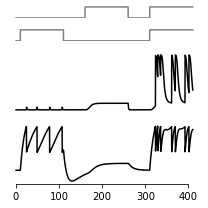

In [60]:
somatic_input = 0.2 * st.StepStimulus([10, 100, 50, 100, 50, 100], [0, 10, 0, 0, 0, 10], TIMESTEP_WIDTH).command.flatten()
dendritic_input = 0.2 * st.StepStimulus([10, 100, 50, 100, 50, 100], [0, 0, 0, 10, 0, 10], TIMESTEP_WIDTH).command.flatten()

response = model(
    somatic_input, 
    dendritic_input
)

spec = gs.GridSpec(4, 1, height_ratios=(0.2, 0.2, 1, 1))

plt.figure(figsize=(3, 3))

plt.subplot(spec[0, 0])
plt.plot(response.time, dendritic_input, '-', color='gray')
pltools.hide_border()

plt.subplot(spec[1, 0])
plt.plot(
    response.time, 
    somatic_input,
    '-', color='gray'
)
pltools.hide_border()

plt.subplot(spec[2, 0])
plt.plot(response.time, response['Vd_tot'], 'k-')
pltools.hide_border()

plt.subplot(spec[3, 0])
plt.plot(response.time, response['Vs_linear'], 'k-')
pltools.hide_border('trl', trim=True)

plt.tight_layout()
plt.savefig('/Users/efharkin/Desktop/bursting.svg')

## Coincidence detection

Somatic output is bigger if dendritic input arrives slightly before or at the same time as somatic input.

In [8]:
synaptic_kernel = st.BiexponentialSynapticKernel(1, 0.1, 20., duration=25., dt=TIMESTEP_WIDTH)

def delayed_pulse(delay: float, total_duration: float = 125.) -> st.ConvolvedStimulus:
    """Create ConvolvedStimulus containing a synaptic pulse with a delayed start."""
    pulse_time = np.zeros(int(total_duration / TIMESTEP_WIDTH - 0.5))
    pulse_time[int(delay / TIMESTEP_WIDTH - 0.5)] = 1.
    pulse = st.ConvolvedStimulus(0, synaptic_kernel)
    pulse.generate(pulse_time, TIMESTEP_WIDTH)
    return pulse

In [40]:
plt.rc('svg', fonttype='none')

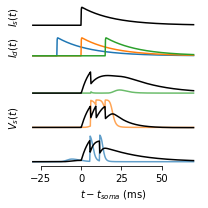

In [46]:
somatic_pulse_time = 30.
somatic_input = delayed_pulse(somatic_pulse_time, 100.)

fig_grid = gs.GridSpec(3, 1, height_ratios=[0.2, 0.2, 1])

plt.figure(figsize=(3, 3))
plt.subplot(fig_grid[0, 0])
somatic_input.plot(color='k', label='Somatic input')
pltools.hide_border()
plt.ylabel('$I_s(t)$')
plt.xlabel('')

input_ax = plt.subplot(fig_grid[1, 0])
pltools.hide_border()

output_ax = plt.subplot(fig_grid[2, 0])
output_ax.set_ylabel('$V_s(t)$')

max_responses = []
for i, delay in tqdm(enumerate(np.linspace(15, 45, 3))):
    dend_pulse = delayed_pulse(delay, 100.)
    dend_pulse.plot(ax=input_ax)
    
    response = model(4 * somatic_input.command.flatten(), 3 * dend_pulse.command.flatten())
    output_ax.plot(
        response.time - somatic_pulse_time, 
        i * 2.5 + response['Vd_tot'], 
        '-',
        alpha=0.7
    )
    output_ax.plot(
        response.time - somatic_pulse_time, 
        i * 2.5 + response['Vs_linear'], 
        'k-'
    )


    
# Set axis labels for traces.
input_ax.set_xlabel('')
input_ax.set_ylabel('$I_d(t)$')
output_ax.set_xlabel('$t - t_{soma}$ (ms)')
pltools.hide_border('trl', trim=True, ax=output_ax)

plt.tight_layout()

plt.savefig('/Users/efharkin/Desktop/coincidence.svg')

## Gain modulation

This one is pretty subtle. Spent some time tweaking parameters manually and didn't get better than this.

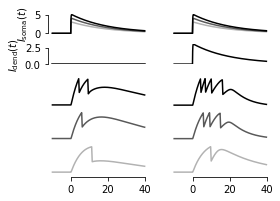

In [53]:
somatic_inputs = delayed_pulse(10, 50)
somatic_inputs.replicate(3)
somatic_inputs.command *= np.linspace(3, 5, 3)[:, np.newaxis]

dendritic_inputs = delayed_pulse(10, 50)
dendritic_inputs.replicate(2)
dendritic_inputs.command *= np.linspace(0, 3, 2)[:, np.newaxis]

spec = gs.GridSpec(3, 2, height_ratios=(0.2, 0.2, 1))
soma_alphas = np.linspace(0.3, 1, somatic_inputs.no_sweeps)

plt.figure(figsize=(4, 3))

for i in range(dendritic_inputs.no_sweeps):
    dendritic_input_ax = plt.subplot(spec[1, i])
    dendritic_input_ax.plot(dendritic_inputs.command[i, :], 'k-')
    dendritic_input_ax.set_ylim(
        dendritic_inputs.command.min() - 0.05, 
        dendritic_inputs.command.max() + 0.05
    )
    if i == 0:
        dendritic_input_ax.set_ylabel('$I_\mathrm{dend}(t)$')
        pltools.hide_border('trb', trim=True, ax=dendritic_input_ax)
    else:
        pltools.hide_border('a', ax=dendritic_input_ax)
    
    somatic_input_ax = plt.subplot(spec[0, i])
    for j in range(somatic_inputs.no_sweeps):
        somatic_input_ax.plot(
            somatic_inputs.time_supp, 
            somatic_inputs.command[j, :],
            color='k',
            alpha=soma_alphas[j]
        )
    if i == 0:
        somatic_input_ax.set_ylabel('$I_\mathrm{soma}(t)$')
        pltools.hide_border('trb', trim=True, ax=somatic_input_ax)
    else:
        pltools.hide_border('a', ax=somatic_input_ax)
        somatic_input_ax.set_ylabel('')
    somatic_input_ax.set_xlabel('')
    
    response_ax = plt.subplot(spec[2, i])
    for j in range(somatic_inputs.no_sweeps):
        response = model(somatic_inputs.command[j, :], dendritic_inputs.command[i, :])
        response_ax.plot(response.time - 10., 2. * j + response['Vs_linear'], color='k', alpha=soma_alphas[j])
    pltools.hide_border('trl', trim=True)
        
plt.savefig('/Users/efharkin/Desktop/gain.svg')

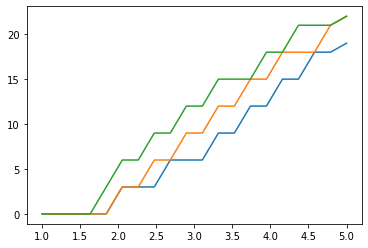

In [43]:
somatic_inputs = delayed_pulse(10, 50)
somatic_inputs.replicate(20)
somatic_intensities = np.linspace(1, 10, 20)
somatic_inputs.command *= somatic_intensities[:, np.newaxis]

dendritic_inputs = delayed_pulse(10, 50)
dendritic_inputs.replicate(3)
dendritic_inputs.command *= np.linspace(0, 3, 3)[:, np.newaxis]

for i in range(dendritic_inputs.no_sweeps):
    no_spikes = []
    for j in range(somatic_inputs.no_sweeps):
        response = model(somatic_inputs.command[j, :], dendritic_inputs.command[i, :])
        no_spikes.append(response['Vs_tot'].astype(np.bool).sum())
    plt.plot(np.linspace(1, 5, 20), no_spikes)

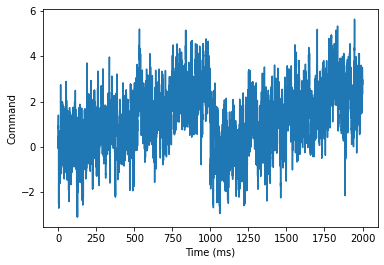

In [86]:
somatic_steps = st.StepStimulus(250. * np.ones(4), np.linspace(0, 2.5, 4), TIMESTEP_WIDTH)
somatic_steps = st.concatenate([somatic_steps] * 2)
ou_noise = st.OUStimulus(
    0., 1, 2., 0., 1., duration=somatic_steps.duration, dt=TIMESTEP_WIDTH
)
somatic_noisy_steps = somatic_steps + ou_noise
somatic_noisy_steps.plot()

dendritic_steps = st.StepStimulus([1000.] * 2, [0, 2], TIMESTEP_WIDTH)
dendritic_noise = st.OUStimulus(0, 1, 2., 0., 1., duration=dendritic_steps.duration, dt=TIMESTEP_WIDTH)
dendritic_noisy_steps = dendritic_steps + dendritic_noise

In [87]:
response = model(somatic_noisy_steps.command.flatten(), dendritic_noisy_steps.command.flatten())

Text(0, 0.5, '$V_\\mathrm{soma}(t)$')

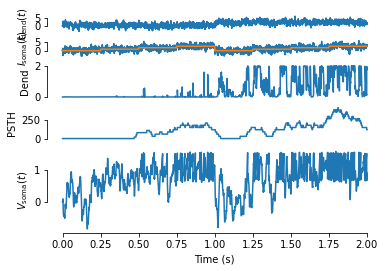

In [89]:
spec = gs.GridSpec(5, 1, height_ratios=(0.2, 0.2, 0.4, 0.4, 1))

plt.subplot(spec[0, :])
plt.plot(dendritic_noisy_steps.time_supp, dendritic_noisy_steps.command.flatten())
plt.ylabel('$I_\mathrm{dend}(t)$')
pltools.hide_border('trb', trim=True)

plt.subplot(spec[1, :])
plt.plot(somatic_noisy_steps.time_supp, somatic_noisy_steps.command.flatten())
plt.plot(somatic_steps.time_supp, somatic_steps.command.flatten())
plt.ylabel('$I_\mathrm{soma}(t)$')
pltools.hide_border('trb', trim=True)

plt.subplot(spec[2, :])
plt.plot(response.time, response['Vd_tot'])
plt.ylabel('Dend')
pltools.hide_border('trb', trim=True)

plt.subplot(spec[3, :])
plt.plot(response.time, np.convolve(response['Vs_tot'].astype(np.bool), np.ones(1000) / 0.1, mode='same'))
pltools.hide_border('trb', trim=True)
plt.ylabel('PSTH')

plt.subplot(spec[4, :])
plt.plot(1e-3 * response.time, response['Vs_linear'])
pltools.hide_border('tr', trim=True)
plt.xlabel('Time (s)')
plt.ylabel('$V_\mathrm{soma}(t)$')

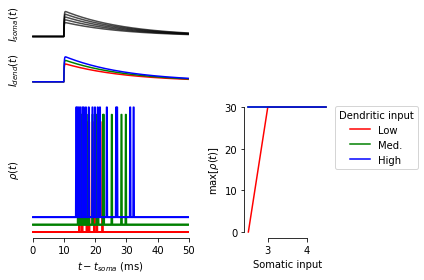

In [26]:
# Set up graded inputs
graded_input = delayed_pulse(10, 50)
graded_input.replicate(5)
intensities = np.linspace(2.5, 4.5, 5)
graded_input.command *= intensities[:, np.newaxis]

# Generat figure
fig_grid = gs.GridSpec(3, 2, height_ratios=[0.2, 0.2, 1], width_ratios=[1, 0.5])

plt.subplot(fig_grid[0, 0])
plt.plot(graded_input.command.T, color='k', alpha=0.7)
pltools.hide_border()
plt.ylabel('$I_{soma}(t)$')
plt.xlabel('')

input_ax = plt.subplot(fig_grid[1, 0])
plt.plot(graded_input.command[0, :], color='r')
plt.plot(graded_input.command[1, :], color='g')
plt.plot(graded_input.command[2, :], color='b')
pltools.hide_border()

output_ax = plt.subplot(fig_grid[2, 0])
output_ax.set_ylabel('$\\rho(t)$')

max_responses = []
for i, (color, dendritic_intensity) in enumerate(zip(['r', 'g', 'b'], [1, 2, 3])):
    for somatic_intensity in range(0, 5):
        response = model(
            1. * graded_input.command[somatic_intensity, :].flatten(), 
            dendritic_intensity * graded_input.command[0, :].flatten()
        )
        max_responses.append(response['Vs_tot'].max())
        output_ax.plot(
            graded_input.time_supp,
            i * 2 + response['Vs_tot'],
            color=color
        )
    
# Set axis labels for traces.
input_ax.set_xlabel('')
input_ax.set_ylabel('$I_{dend}(t)$')
output_ax.set_xlabel('$t - t_{soma}$ (ms)')
pltools.hide_border('trl', trim=True, ax=output_ax)

max_responses = np.reshape(max_responses, (3, 5))

plt.subplot(fig_grid[2, 1])
for i, (col, lab) in enumerate(zip(['r', 'g', 'b'], ['Low', 'Med.', 'High'])):
    plt.plot(intensities, max_responses[i], color=col, label=lab)
plt.legend(title='Dendritic input', loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Somatic input')
plt.ylabel('$\\mathrm{max}[\\rho(t)]$')
pltools.hide_border('tr', trim=True)

plt.tight_layout()